In [ ]:
image = requests.get('http:'+data['current']['condition']['icon'])
img = Image.open(BytesIO(image.content))
img

In [3]:
import os
import discord
from discord.ext import commands
#from PIL import Image
#from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
#nest_asyncio only necessary for running in anaconda
    #allows running of loop necessary for server
import nest_asyncio
nest_asyncio.apply()

In [70]:
with open('.secrets/token.json') as f:
    token = json.load(f)

TOKEN = token['token']
bot = commands.Bot(command_prefix='!')

@bot.event
async def on_ready():
    print(f'{client.user} has connected.')

@bot.command()
async def test(ctx):
    await ctx.send('Hello!')

@bot.command()
async def weather(ctx, location = '07024'):
    #Retrieve API key
    with open('.secrets/APIs.json') as f:
        APIs = json.load(f)
    API_KEY = APIs['weather']
    #Format url with key, optional zipcode argument
    url = 'http://api.weatherapi.com/v1/forecast.json?key='+API_KEY+'&q='+location+'&days=3&aqi=no'
    response = requests.get(url)
    #Return response as json
    data = response.json()
    
    #Set json variables
    current_weather = data['current']
    daily_weather = data['forecast']['forecastday'][0]['day']
    
    #Instantiate variable for current UV index note
    uv_index_now = ''
    #Set UV index note
    if current_weather['uv'] < 3:
        uv_index_now = 'low'
    elif current_weather['uv'] in list(range(3,6)):
        uv_index_now = 'moderate'
    elif current_weather['uv'] in list(range(6,9)):
        uv_index_now = 'high'
    elif current_weather['uv'] in list(range(9,11)):
        uv_index_now = 'very high'
    else:
        uv_index_now = 'extremely high'

    #Duplicate above process for daily forecast
    uv_index_day = ''
    if daily_weather['uv'] < 3:
        uv_index_day = 'low'
    elif daily_weather['uv'] in list(range(3,6)):
        uv_index_day = 'moderate'
    elif daily_weather['uv'] in list(range(6,9)):
        uv_index_day = 'high'
    elif daily_weather['uv'] in list(range(9,11)):
        uv_index_day = 'very high'
    else:
        uv_index_day = 'extremely high'
    
    #Check for rain or snow
    weather_event = ''
    if daily_weather['daily_will_it_rain'] == 1 and daily_weather['daily_will_it_snow'] == 1:
        weather_event = 'Be careful today! Rain and Snow expected!'
    elif daily_weather['daily_will_it_rain'] == 1:
        weather_event = f"{daily_weather['daily_chance_of_rain']}% chance of rain"
    elif daily_weather['daily_will_it_snow'] == 1:
        weather_event = f"{daily_weather['daily_chance_of_snow']}% chance of snow"
    else:
        weather_event = 'No rain or snow expected today'
    
    #Send all weather data
    await ctx.send(f'''Here's today's forecast for {data['location']['name']}, {data['location']['region']}:
    
Right now it is {current_weather['condition']['text'].lower()} with:
    Temperature: {current_weather['temp_f']}F / {current_weather['temp_c']}C
    Feels like: {current_weather['feelslike_f']}F / {current_weather['feelslike_c']}C
    Humidity is: {current_weather['humidity']}%
    
    UV index is {uv_index_now} at: {current_weather['uv']}
    Cloud coverage is {current_weather['cloud']}%
    Wind Speed is {current_weather['wind_mph']}mph with {current_weather['gust_mph']}mph gusts
        
Overall, {daily_weather['condition']['text'].lower()} today with:
    {weather_event}
    High of: {daily_weather['maxtemp_f']}F / {daily_weather['maxtemp_c']}C
    Low of: {daily_weather['mintemp_f']}F / {daily_weather['mintemp_c']}C
    UV index is {uv_index_day} at: {daily_weather['uv']}
    Avg humidity will be: {daily_weather['avghumidity']}

Here is your hourly forecast:''')
    
    #Graph hourly weather data
    columns = ['time', 'temp_f', 'feelslike_f', 'chance_of_rain', 'chance_of_snow']
    hourly_forecast = pd.DataFrame(data['forecast']['forecastday'][0]['hour'])[columns]
    #Alter data to only display hour
    hourly_forecast['time'] = hourly_forecast['time'].map(lambda x: x[-5:-3])
    #Change percent chance of rain or snow from string to float
    hourly_forecast = hourly_forecast.astype({'chance_of_rain': np.float,
                                              'chance_of_snow': np.float})
    #Set seaborn theme and stacked graphs
    sns.set_theme()
    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot(hourly_forecast['time'],
            hourly_forecast['temp_f']
           )
    ax.plot(hourly_forecast['time'],
            hourly_forecast['feelslike_f']
           )

    ax.plot(hourly_forecast['time'],
            hourly_forecast['chance_of_rain'],
            '--',
            color = 'c'
           )
    ax.plot(hourly_forecast['time'],
            hourly_forecast['chance_of_snow'],
            '-.',
            color = 'slategrey'
           )

    ax.set_yticks(list(range(0,100,10)))
    ax.legend(['Actual Temp', 'Feels Like', 'Chance of Rain', 'Chance of Snow'])
    plt.suptitle(f'Hourly Forecast for {data["forecast"]["forecastday"][0]["date"]}')
    #Save graph
    plt.savefig('plot.jpg')
    file = discord.File('plot.jpg')
    #Send graph
    await ctx.send(file = file)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000026EE0152280>


Ignoring exception in on_ready
Traceback (most recent call last):
  File "C:\Users\IM\anaconda3\lib\site-packages\discord\client.py", line 343, in _run_event
    await coro(*args, **kwargs)
  File "<ipython-input-70-c6b4aa698f24>", line 9, in on_ready
    print(f'{client.user} has connected.')
NameError: name 'client' is not defined


RuntimeError: Cannot close a running event loop

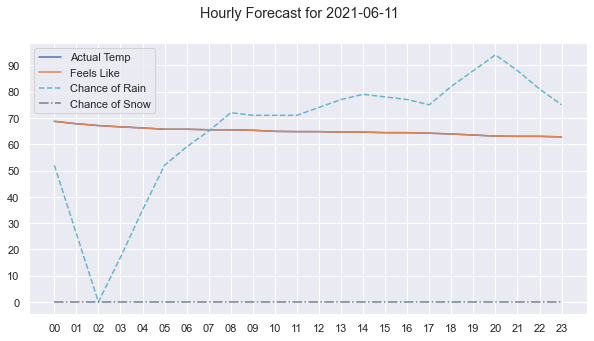

In [71]:
bot.run(TOKEN)

In [66]:
data

{'location': {'name': 'Fort Lee',
  'region': 'New Jersey',
  'country': 'USA',
  'lat': 40.85,
  'lon': -73.98,
  'tz_id': 'America/New_York',
  'localtime_epoch': 1623364684,
  'localtime': '2021-06-10 18:38'},
 'current': {'temp_c': 24.4,
  'temp_f': 75.9,
  'condition': {'text': 'Sunny',
   'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png'},
  'wind_mph': 0.0,
  'wind_kph': 0.0,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 37,
  'cloud': 0,
  'feelslike_c': 24.6,
  'feelslike_f': 76.3,
  'uv': 7.0,
  'gust_mph': 12.5,
  'gust_kph': 20.2},
 'forecast': {'forecastday': [{'date': '2021-06-10',
    'day': {'maxtemp_c': 28.5,
     'maxtemp_f': 83.3,
     'mintemp_c': 21.9,
     'mintemp_f': 71.4,
     'avgtemp_c': 24.8,
     'avgtemp_f': 76.7,
     'maxwind_kph': 21.2,
     'totalprecip_mm': 0.0,
     'totalprecip_in': 0.0,
     'avghumidity': 50.0,
     'daily_will_it_rain': 0,
     'daily_chance_of_rain': '0',
     'daily_will_it_snow': 0,
     'daily_chance_of_snow': 

In [65]:
data['forecast']['forecastday']

[{'date': '2021-06-10',
  'day': {'maxtemp_c': 28.5,
   'maxtemp_f': 83.3,
   'mintemp_c': 21.9,
   'mintemp_f': 71.4,
   'avgtemp_c': 24.8,
   'avgtemp_f': 76.7,
   'maxwind_kph': 21.2,
   'totalprecip_mm': 0.0,
   'totalprecip_in': 0.0,
   'avghumidity': 50.0,
   'daily_will_it_rain': 0,
   'daily_chance_of_rain': '0',
   'daily_will_it_snow': 0,
   'daily_chance_of_snow': '0',
   'condition': {'text': 'Partly cloudy',
    'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png'},
   'uv': 9.0},
  'astro': {},
  'hour': [{'time': '2021-06-10 00:00',
    'temp_c': 24.8,
    'temp_f': 76.6,
    'condition': {'text': 'Partly cloudy',
     'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png'},
    'precip_mm': 0.1,
    'precip_in': 0.0,
    'humidity': 77,
    'cloud': 59,
    'feelslike_c': 27.0,
    'feelslike_f': 80.6,
    'windchill_c': 24.8,
    'windchill_f': 76.6,
    'heatindex_c': 27.0,
    'heatindex_f': 80.6,
    'will_it_rain': 0,
    'chance_of_rain': '41',
    'will_i

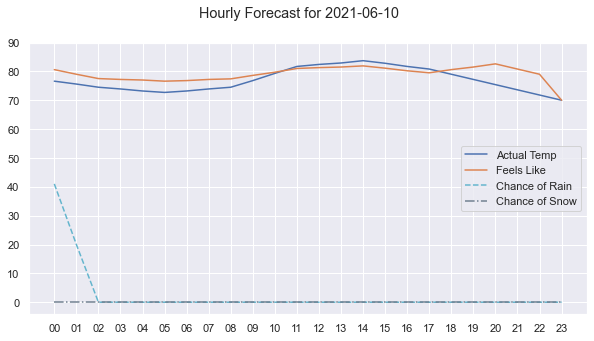

In [62]:
columns = ['time', 'temp_f', 'feelslike_f', 'chance_of_rain', 'chance_of_snow']
hourly_forecast = pd.DataFrame(data['forecast']['forecastday'][0]['hour'])[columns]
hourly_forecast['time'] = hourly_forecast['time'].map(lambda x: x[-5:-3])
hourly_forecast = hourly_forecast.astype({'chance_of_rain': np.float,
                                          'chance_of_snow': np.float})
sns.set_theme()
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(hourly_forecast['time'],
        hourly_forecast['temp_f']
       )
ax.plot(hourly_forecast['time'],
        hourly_forecast['feelslike_f']
       )

ax.plot(hourly_forecast['time'],
        hourly_forecast['chance_of_rain'],
        '--',
        color = 'c'
       )
ax.plot(hourly_forecast['time'],
        hourly_forecast['chance_of_snow'],
        '-.',
        color = 'slategrey'
       )


ax.set_yticks(list(range(0,100,10)))
ax.legend(['Actual Temp', 'Feels Like', 'Chance of Rain', 'Chance of Snow'])
plt.suptitle(f'Hourly Forecast for {data["forecast"]["forecastday"][0]["date"]}');

In [ ]:
    sns.set_theme()
    fig, ax = plt.subplots(2,1, figsize = (20,10), sharex = True)

    ax[0].plot(hourly_forecast['time'],
               hourly_forecast['temp_f']
               )
    ax[0].plot(hourly_forecast['time'],
               hourly_forecast['feelslike_f']
               )

    ax[1].plot(hourly_forecast['time'],
               hourly_forecast['chance_of_rain']
               )
    ax[1].plot(hourly_forecast['time'],
               hourly_forecast['chance_of_snow']
               )

    ax[0].set_yticks(list(range(0,100,10)))
    ax[1].set_yticks(list(range(0,100,10)))
    ax[0].legend(['Actual Temp', 'Feels Like'])
    ax[1].legend(['Chance of Rain', 'Chance of Snow'])
    plt.suptitle(f'Hourly Forecast for {data["forecast"]["forecastday"][0]["date"]}')

In [61]:
with open('.secrets/APIs.json') as f:
    APIs = json.load(f)
API_KEY = APIs['weather']

#Format url with key, optional zipcode argument
url = 'http://api.weatherapi.com/v1/forecast.json?key='+API_KEY+'&q=07024&days=3&aqi=no'
response = requests.get(url)

#Return response as json
data = response.json()